## Load Data and Prepare Features
Load train and validation splits, extract features and targets, and handle missing values using median.


In [2]:
# ============================================================================
# Load Data and Prepare Features
# ============================================================================

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# Load train and validation splits produced by preprocessing_v2
df_train = pd.read_csv("data/splits/train.csv")
df_val   = pd.read_csv("data/splits/val.csv")

print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
df_train.head()

Train shape: (64, 67)
Val shape: (14, 67)


,flightDate_month_day,is_weekend,is_public_holiday,days_from_summer_start,day_of_month,flight_day_of_week,flight_month,1 days to departure,2 days to departure,3 days to departure,...,51 days to departure,52 days to departure,53 days to departure,54 days to departure,55 days to departure,56 days to departure,57 days to departure,58 days to departure,59 days to departure,60 days to departure
0,07-02,1,0,0.340659,0.033333,0.833333,0.5,640.823462,549.756562,1307.436364,...,457.872143,462.339829,466.807514,471.275200,482.408065,486.061111,488.032000,482.324815,474.987407,467.650000
1,08-17,0,0,0.846154,0.533333,0.333333,1.0,568.155556,488.812121,449.751515,...,528.404815,527.493333,537.604615,534.180673,530.756731,527.332788,523.908846,520.256242,516.603638,512.951034
2,06-10,0,0,0.098901,0.300000,0.666667,0.0,818.848333,1485.269167,1157.506667,...,428.910893,426.145000,421.511048,416.877097,416.877097,416.877097,416.877097,416.877097,416.877097,416.877097
3,08-10,0,0,0.769231,0.300000,0.333333,1.0,467.033667,430.740937,428.373030,...,502.431970,494.063333,507.381765,503.782059,505.399688,492.409091,488.206000,495.352813,494.441471,516.087097
4,06-06,0,0,0.054945,0.166667,0.000000,0.0,558.055714,550.206000,530.795238,...,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143,398.401143


In [4]:
# ============================================================================
# Define Feature Columns and Target Columns
# ============================================================================

# Final feature set from preprocessing_v2 (V7 pipeline)
feature_cols = [
    "day_of_month",
    "is_weekend",
    "is_public_holiday",
    "days_from_summer_start",
    "flight_day_of_week",
    "flight_month",
]

# All days-to-departure columns (60 outputs)
target_cols = [c for c in df_train.columns if "days to departure" in c]
target_cols = sorted(target_cols, key=lambda x: int(x.split()[0]))

print("Number of target columns:", len(target_cols))
print("Example target cols:", target_cols[:5])

# Build X and y
X_train = df_train[feature_cols].values
X_val   = df_val[feature_cols].values

y_train = df_train[target_cols].values
y_val   = df_val[target_cols].values

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Safety: handle any remaining missing values in targets
imputer = SimpleImputer(strategy="median")
y_train = imputer.fit_transform(y_train)
y_val   = imputer.transform(y_val)

Number of target columns: 60
Example target cols: ['1 days to departure', '2 days to departure', '3 days to departure', '4 days to departure', '5 days to departure']
X_train shape: (64, 6)
y_train shape: (64, 60)
X_val shape: (14, 6)
y_val shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [5]:
# ============================================================================
# Train Multi-Output XGBoost Model
# ============================================================================

base_model = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model = MultiOutputRegressor(base_model)

print("Training model...")
model.fit(X_train, y_train)
print("Training completed.")

# Predict on validation set
y_val_pred = model.predict(X_val)
print("Prediction completed.")

Training model...
Training completed.
Prediction completed.


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY

Overall MAE: 61.72
Total predictions: 840
Number of samples: 14
Outputs per sample: 60

First rows:
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  482.220632  539.257385       57.036754
1            0                  2  450.498510  539.638123       89.139613
2            0                  3  438.754291  539.211121      100.456829
3            0                  4  452.747970  542.382263       89.634293
4            0                  5  455.068126  545.729431       90.661305
5            0                  6  460.148541  547.477173       87.328632
6            0                  7  489.979531  549.784241       59.804709
7            0                  8  512.223577  549.865967       37.642390
8            0                  9  493.954358  551.427185       57.472827
9            0                 10  487.194303  549.187378       61.993075
10           0                 11  473.013909  552.851

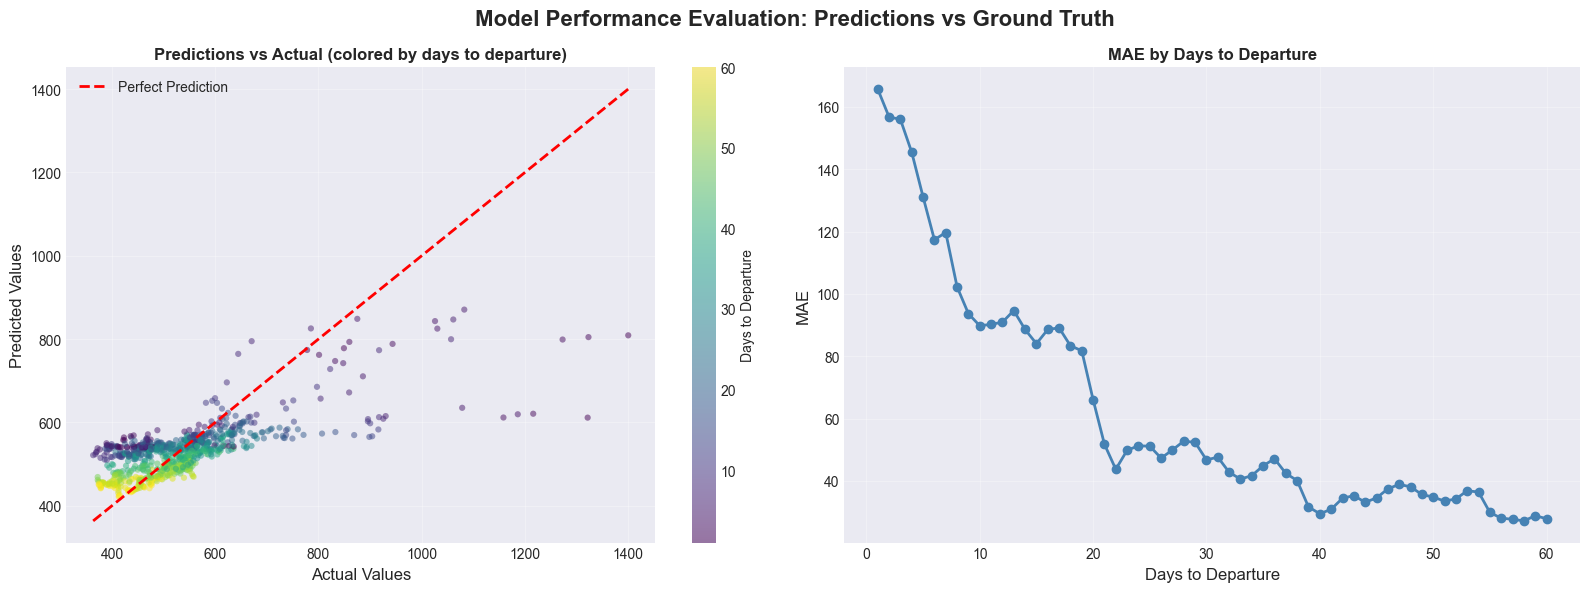

In [36]:
# ============================================================================
# Model Evaluation Visualizations
# ============================================================================

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Flatten predictions and actuals for comparison DataFrame
n_samples, n_outputs = y_val.shape
comparison_data = []

for sample_idx in range(n_samples):
    for output_idx in range(n_outputs):
        actual = y_val[sample_idx, output_idx]
        predicted = y_val_pred[sample_idx, output_idx]
        abs_error = abs(actual - predicted)

        days_to_departure = int(target_cols[output_idx].split()[0])

        comparison_data.append({
            "sample_idx": sample_idx,
            "days_to_departure": days_to_departure,
            "actual": actual,
            "predicted": predicted,
            "absolute_error": abs_error
        })

comparison_df = pd.DataFrame(comparison_data)

# Summary statistics
print("\n" + "="*80)
print("PREDICTION COMPARISON SUMMARY")
print("="*80)

mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred[:, i])
    for i in range(n_outputs)
]

overall_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nOverall MAE: {overall_mae:.2f}")
print(f"Total predictions: {len(comparison_df)}")
print(f"Number of samples: {n_samples}")
print(f"Outputs per sample: {n_outputs}")
print("\nFirst rows:")
print(comparison_df.head(20))

# ============================================================================
# Visualizations: Predictions vs Actual and MAE by Days to Departure
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Evaluation: Predictions vs Ground Truth',
             fontsize=16, fontweight='bold')

# -------------------------------------------------------------
# Plot 1: Scatter Plot - Predictions vs Actual
# -------------------------------------------------------------

ax1 = axes[0]
scatter = ax1.scatter(
    comparison_df['actual'],
    comparison_df['predicted'],
    alpha=0.5,
    s=20,
    c=comparison_df['days_to_departure'],
    cmap='viridis',
    edgecolors='none'
)

min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Days to Departure')

# -------------------------------------------------------------
# Plot 2: MAE by Days to Departure
# -------------------------------------------------------------

ax2 = axes[1]
days_list = [int(col.split()[0]) for col in target_cols]

ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
ax2.set_xlabel('Days to Departure', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 61, 10))

plt.tight_layout()
plt.show()

## Model Hyperparamter Tuning
Find the best max depth, num estimators, learning rate for optimal results.
Grid search utilized.

In [6]:
# Grid Search for Hyperparameter Tuning

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import numpy as np

#  Base multi-output XGB model
base_xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

multioutput_xgb = MultiOutputRegressor(base_xgb)

# the Param grid
param_grid = {
    "estimator__max_depth": [3, 5, 7],
    "estimator__learning_rate": [0.03, 0.05, 0.1],
    "estimator__n_estimators": [100, 200],
    "estimator__subsample": [0.7, 1.0],
    "estimator__colsample_bytree": [0.7, 1.0],
    "estimator__reg_lambda": [1.0, 2.0],
    "estimator__reg_alpha": [0.0, 1.0],
}

# MAE across all 60 horizons, lower is better
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=multioutput_xgb,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
)

print("Running grid search...")
grid_search.fit(X_train, y_train)
print("Grid search done.")

print("\nBest params:")
print(grid_search.best_params_)

print(f"\nBest CV MAE (mean over folds): {-grid_search.best_score_:.4f}")

# Evaluate best model on your held-out validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation MAE with best params: {val_mae:.4f}")


Running grid search...
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=1.0; total time=   1.9s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=2.0, estimator__subsample=0.7; total time=   1.9s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=1.0; total time=   1.9s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   1.9s
[CV] END estimator

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x12365ca10>>
Traceback (most recent call last):
  File "/Users/brandonfagiolo/miniconda3/envs/aml/lib/python3.11/site-packages/xgboost/core.py", line 606, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=200, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   3.3s


KeyboardInterrupt: 

In [7]:
# Training with Optimal Hyperparameters
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Train multi-output regression model using XGBoost
# Use MultiOutputRegressor to handle multiple target outputs
base_model = XGBRegressor(
    max_depth=3,
    learning_rate=0.03,
    n_estimators=100,
    subsample=0.7,
    colsample_bytree=1.0,
    reg_lambda=2.0,
    reg_alpha=0.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)


# baseline per-horizon mean predictor to check overfitting
baseline_mean = y_train.mean(axis=0)  # shape (60,)
y_val_baseline = np.tile(baseline_mean, (y_val.shape[0], 1))

baseline_overall_mae = mean_absolute_error(y_val, y_val_baseline)
print(f"Baseline (per-horizon mean) Overall MAE: {baseline_overall_mae:.2f}")

# baseline per-horizon median predictor to check overfitting
baseline_median = np.median(y_train, axis=0)
y_val_baseline_med = np.tile(baseline_median, (y_val.shape[0], 1))
baseline_median_mae = mean_absolute_error(y_val, y_val_baseline_med)
print(f"Baseline (per-horizon median) Overall MAE: {baseline_median_mae:.2f}")


model = MultiOutputRegressor(base_model)
print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

y_val_pred = model.predict(X_val)
print("Predictions completed!")


Baseline (per-horizon mean) Overall MAE: 87.02
Baseline (per-horizon median) Overall MAE: 84.38
Training model...
Training completed!
Predictions completed!


In [ ]:
# Overfitting check: Train MAE vs Validation MAE
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


## Benchmarking: Comparison with Ridge Regression
A simpler linear regression model can help us properly understand XGBoost's performance with this as a reference point

Training Ridge multi-output model...
Training completed!
Predictions completed!

================ Ridge Regression Summary ================
Ridge Train MAE: 70.22
Ridge Validation MAE: 72.01

Per-output MAE (Ridge): mean=72.01, min=39.06, max=183.34


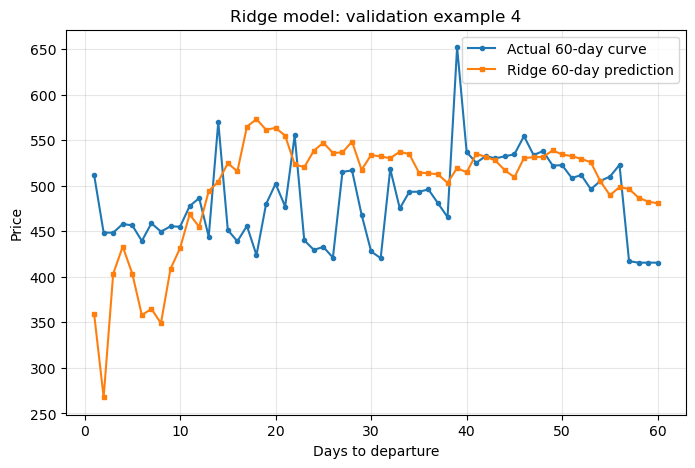

In [8]:
# using ridge regression instead of xgboost -> simpler approach

from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Define and train Ridge multi-output model
ridge_base = Ridge(alpha=1.0, random_state=42)  # L2-regularized linear model
ridge_model = MultiOutputRegressor(ridge_base)

print("Training Ridge multi-output model...")
ridge_model.fit(X_train, y_train)
print("Training completed!")

# Predictions on train and validation
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)
print("Predictions completed!")

# Compute MAE in original 60-day price space
ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_val_mae = mean_absolute_error(y_val, y_val_pred_ridge)

print("\n================ Ridge Regression Summary ================")
print(f"Ridge Train MAE: {ridge_train_mae:.2f}")
print(f"Ridge Validation MAE: {ridge_val_mae:.2f}")

# 4. Per-horizon MAE
n_samples, n_outputs = y_val.shape
ridge_mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred_ridge[:, i]) for i in range(n_outputs)
]

print(
    f"\nPer-output MAE (Ridge): "
    f"mean={np.mean(ridge_mae_per_output):.2f}, "
    f"min={np.min(ridge_mae_per_output):.2f}, "
    f"max={np.max(ridge_mae_per_output):.2f}"
)

# compare one validation curve visually
example_idx = 4  # pick any validation example
days = np.arange(1, y_val.shape[1] + 1)

plt.figure(figsize=(8, 5))
plt.plot(days, y_val[example_idx], label="Actual 60-day curve", marker="o", ms=3)
plt.plot(
    days,
    y_val_pred_ridge[example_idx],
    label="Ridge 60-day prediction",
    marker="s",
    ms=3,
)

plt.xlabel("Days to departure")
plt.ylabel("Price")
plt.title(f"Ridge model: validation example {example_idx}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Alternative Approach: 3 segment piece-wise curve
Focusing on improving generalization, a simplified XGBoost model focusing on predicting solely the early, middle, and late window average price in the 60 day range.

Segmented target shapes (train/val): (64, 3) (14, 3)
Training 3-segment model...
Training completed!
3-segment model Train MAE (price space): 58.76
3-segment model Validation MAE (price space): 63.97


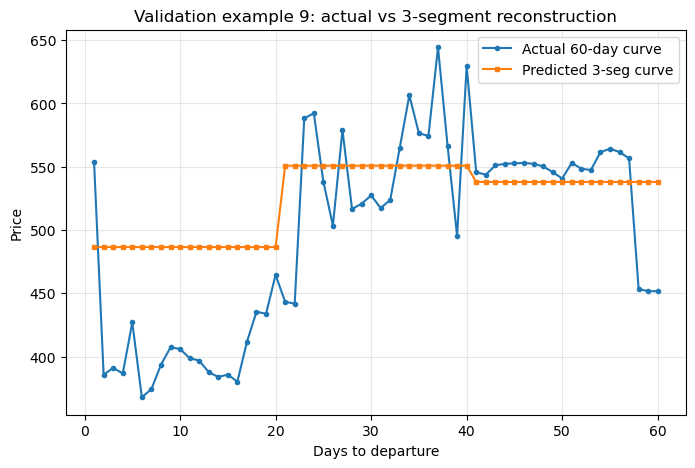

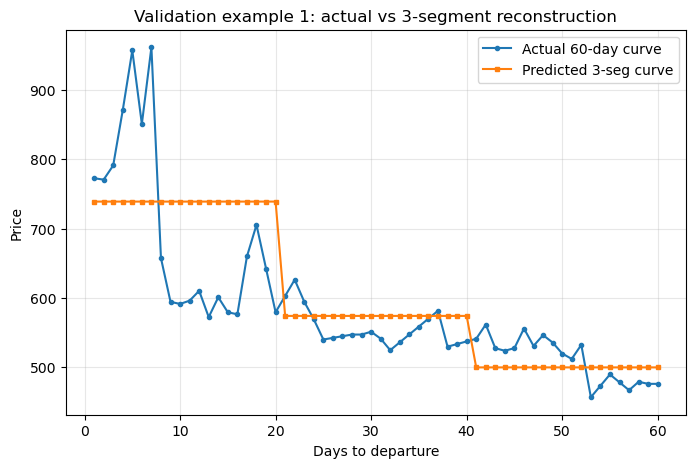

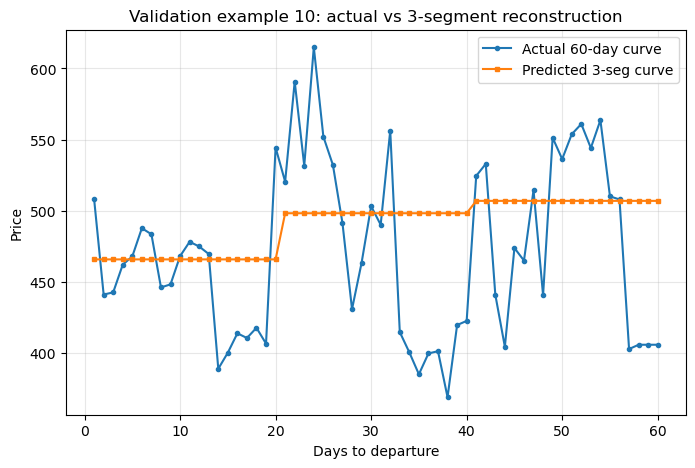


Average segment means over validation set:
  Early window (60-41 days): 478.40
  Mid window   (40-21 days): 543.25
  Late window  (20-1 days):  580.17

Approximate dip/peak regions (using 3-segment means):
  Lowest average prices in: early (60-41)
  Highest average prices in: late (20-1)


In [9]:
# Alternative approach: 3-segment piecewise price profile

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Build 3-segment targets (early, mid, late) from 60-day prices -> goal is to show general curvature
# y_train, y_val assumed shape: (n_samples, 60) with horizons 1..60 days

# this defines segment boundaries in terms of "days to departure"
# segment 1: days 60-41, segment 2: days 40-21, segment 3: days 20-1
horizons = np.arange(1, y_train.shape[1] + 1)

seg1_mask = (horizons >= 41) & (horizons <= 60)
seg2_mask = (horizons >= 21) & (horizons <= 40)
seg3_mask = (horizons >= 1) & (horizons <= 20)


def segment_means(y, mask):
    # mean over columns in this mask, per row
    return np.nanmean(y[:, mask], axis=1, keepdims=True)


y_train_seg1 = segment_means(y_train, seg1_mask)  # shape (n_samples, 1)
y_train_seg2 = segment_means(y_train, seg2_mask)
y_train_seg3 = segment_means(y_train, seg3_mask)

y_val_seg1 = segment_means(y_val, seg1_mask)
y_val_seg2 = segment_means(y_val, seg2_mask)
y_val_seg3 = segment_means(y_val, seg3_mask)

y_train_seg = np.hstack([y_train_seg1, y_train_seg2, y_train_seg3])
y_val_seg = np.hstack([y_val_seg1, y_val_seg2, y_val_seg3])

print("Segmented target shapes (train/val):", y_train_seg.shape, y_val_seg.shape)

# Train multi-output XGBoost on segment means
seg_base_model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=80,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2.0,
    reg_alpha=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

seg_model = MultiOutputRegressor(seg_base_model)
print("Training 3-segment model...")
seg_model.fit(X_train, y_train_seg)
print("Training completed!")

# predictions in segment space
y_train_seg_pred = seg_model.predict(X_train)
y_val_seg_pred = seg_model.predict(X_val)


# remake 60-day curves from predicted segments
def reconstruct_from_segments(seg_pred, n_outputs):
    """
    seg_pred: (n_samples, 3) with [m1, m2, m3]
    returns reconstructed curves of shape (n_samples, n_outputs)
    """
    n_samples = seg_pred.shape[0]
    recon = np.zeros((n_samples, n_outputs))

    m1 = seg_pred[:, 0][:, None]
    m2 = seg_pred[:, 1][:, None]
    m3 = seg_pred[:, 2][:, None]

    recon[:, seg1_mask] = m1
    recon[:, seg2_mask] = m2
    recon[:, seg3_mask] = m3
    return recon


y_train_recon = reconstruct_from_segments(y_train_seg_pred, y_train.shape[1])
y_val_recon = reconstruct_from_segments(y_val_seg_pred, y_val.shape[1])

# computes MAE
train_mae_seg = mean_absolute_error(y_train, y_train_recon)
val_mae_seg = mean_absolute_error(y_val, y_val_recon)

print(f"3-segment model Train MAE (price space): {train_mae_seg:.2f}")
print(f"3-segment model Validation MAE (price space): {val_mae_seg:.2f}")

# plots
rng = np.random.default_rng(42)  # for reproducibility
example_indices = rng.choice(y_val.shape[0], size=min(3, y_val.shape[0]), replace=False)

days = np.arange(1, y_val.shape[1] + 1)

for idx in example_indices:
    plt.figure(figsize=(8, 5))
    plt.plot(days, y_val[idx], label="Actual 60-day curve", marker="o", ms=3)
    plt.plot(days, y_val_recon[idx], label="Predicted 3-seg curve", marker="s", ms=3)

    plt.xlabel("Days to departure")
    plt.ylabel("Price")
    plt.title(f"Validation example {idx}: actual vs 3-segment reconstruction")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# results summary to make sense of it all

# average segment means over all validation examples
avg_seg_means = y_val_seg.mean(axis=0)  # [m1, m2, m3]
m1, m2, m3 = avg_seg_means

print("\nAverage segment means over validation set:")
print(f"  Early window (60-41 days): {m1:.2f}")
print(f"  Mid window   (40-21 days): {m2:.2f}")
print(f"  Late window  (20-1 days):  {m3:.2f}")

# interpretation of dip/peak
segments = ["early (60-41)", "mid (40-21)", "late (20-1)"]
vals = [m1, m2, m3]
min_idx = int(np.argmin(vals))
max_idx = int(np.argmax(vals))

print("\nApproximate dip/peak regions (using 3-segment means):")
print(f"  Lowest average prices in: {segments[min_idx]}")
print(f"  Highest average prices in: {segments[max_idx]}")


## Running on Test Set


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

MAX_DAY_TARGET = 60

df_train = pd.read_csv("data/splits/train.csv")
df_val = pd.read_csv("data/splits/val.csv")
df_test = pd.read_csv("data/splits/test.csv")

binary_features = [
    "is_weekend",
    "is_public_holiday",
]

continuous_features = [
    "day_of_month",
    "days_from_summer_start",
    "flight_day_of_week",
    "flight_month",
]

scaler = MinMaxScaler()
df_train[continuous_features] = scaler.fit_transform(df_train[continuous_features])
df_val[continuous_features] = scaler.transform(df_val[continuous_features])
df_test[continuous_features] = scaler.transform(df_test[continuous_features])

feature_cols = binary_features + continuous_features
X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values
X_test = df_test[feature_cols].values

all_target_cols = [c for c in df_train.columns if "days to departure" in c]


def extract_day(c):
    return int(c.split(" ")[0])


target_cols = [
    c
    for c in sorted(all_target_cols, key=extract_day)
    if extract_day(c) <= MAX_DAY_TARGET
]

y_train = df_train[target_cols].values
y_val = df_val[target_cols].values
y_test = df_test[target_cols].values

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
y_train = imputer.fit_transform(y_train)
y_val = imputer.transform(y_val)
y_test = imputer.transform(y_test)

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation targets shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")

y_test_pred_xgb = model.predict(X_test)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
print(f"XGBoost Test MAE: {test_mae_xgb:.2f}")


Training features shape: (64, 6)
Training targets shape: (64, 60)
Validation features shape: (14, 6)
Validation targets shape: (14, 60)
Test features shape: (14, 6)
Test targets shape: (14, 60)
XGBoost Test MAE: 72.02


In [13]:
# Evaluate Ridge model on test set
y_test_pred_ridge = ridge_model.predict(X_test)

test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
print(f"Ridge Test MAE: {test_mae_ridge:.2f}")


Ridge Test MAE: 89.25


In [14]:
# Evaluate 3-segment model on test set
y_test_seg1 = segment_means(y_test, seg1_mask)
y_test_seg2 = segment_means(y_test, seg2_mask)
y_test_seg3 = segment_means(y_test, seg3_mask)
y_test_seg = np.hstack([y_test_seg1, y_test_seg2, y_test_seg3])

y_test_seg_pred = seg_model.predict(X_test)

y_test_recon = reconstruct_from_segments(y_test_seg_pred, y_test.shape[1])

test_mae_seg = mean_absolute_error(y_test, y_test_recon)
print(f"3-segment XGBoost Test MAE (price space): {test_mae_seg:.2f}")


3-segment XGBoost Test MAE (price space): 72.03


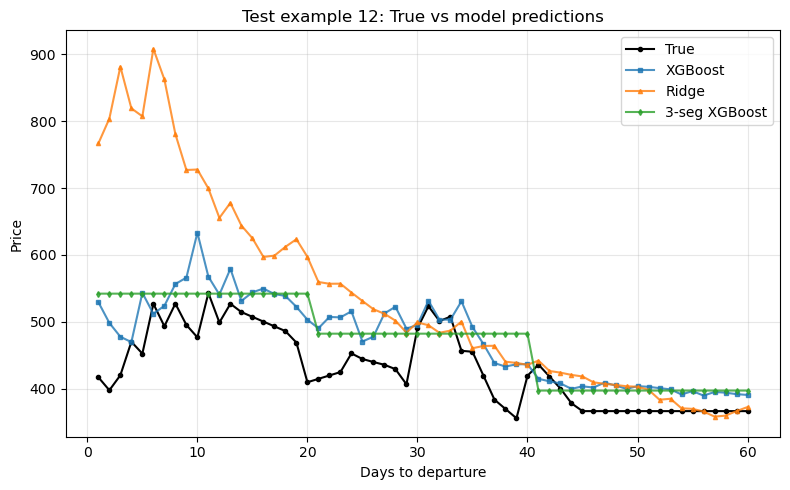

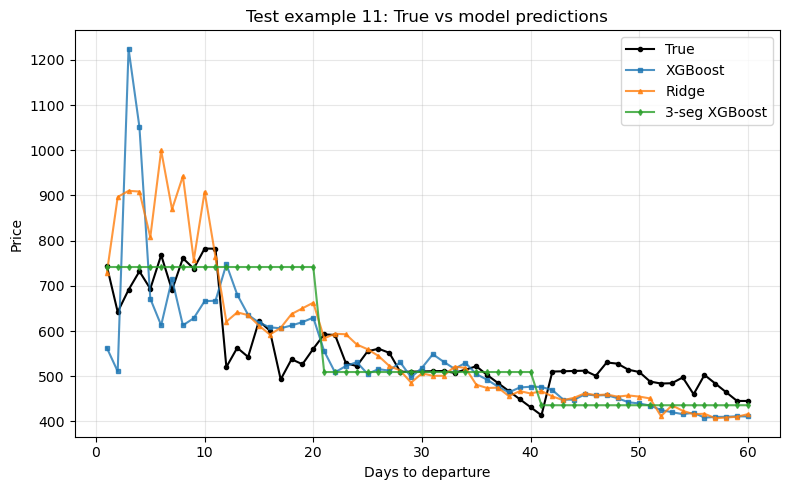

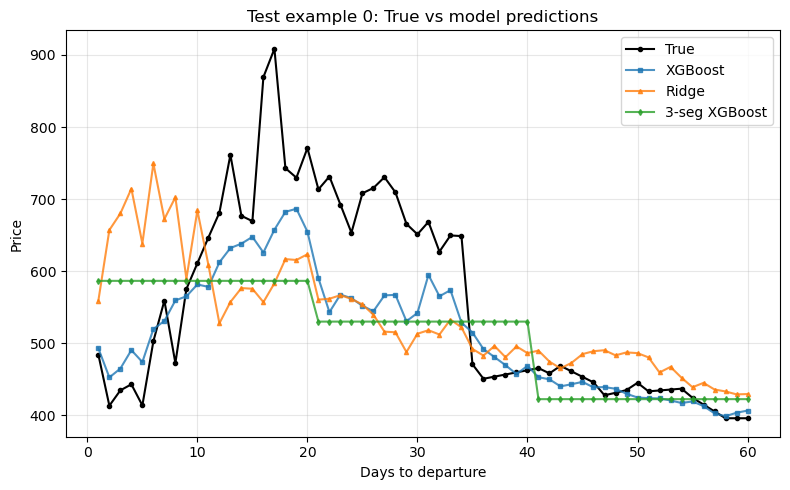

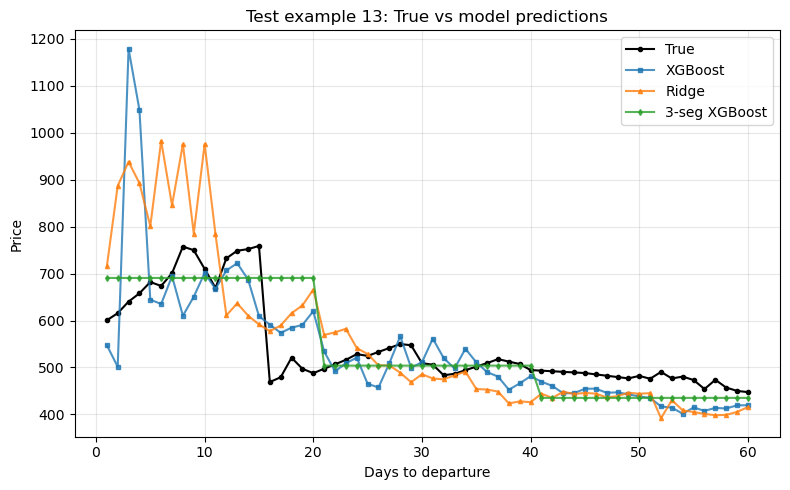

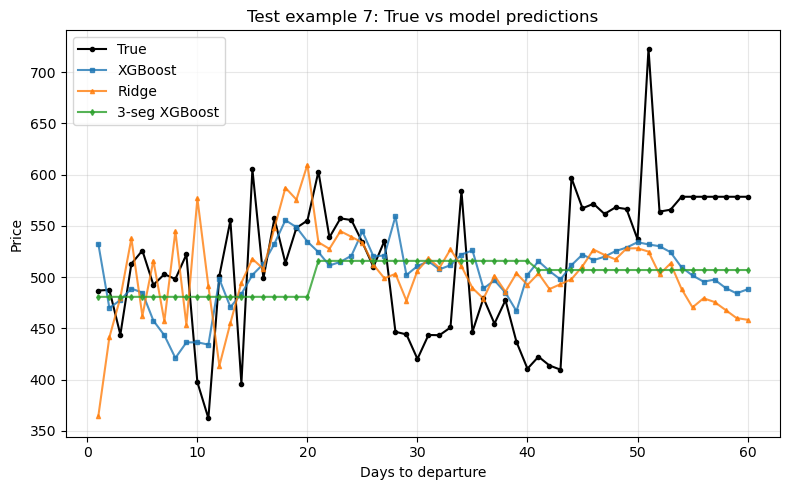

In [15]:
# Plot comparisons of true vs predicted for each model on random test examples
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)
n_examples = min(5, y_test.shape[0])
example_indices = rng.choice(y_test.shape[0], size=n_examples, replace=False)

days = np.arange(1, y_test.shape[1] + 1)

for idx in example_indices:
    plt.figure(figsize=(8, 5))
    plt.plot(days, y_test[idx], label="True", color="black", marker="o", ms=3)
    plt.plot(days, y_test_pred_xgb[idx], label="XGBoost", marker="s", ms=3, alpha=0.8)
    plt.plot(days, y_test_pred_ridge[idx], label="Ridge", marker="^", ms=3, alpha=0.8)
    plt.plot(
        days, y_test_recon[idx], label="3-seg XGBoost", marker="d", ms=3, alpha=0.8
    )

    plt.xlabel("Days to departure")
    plt.ylabel("Price")
    plt.title(f"Test example {idx}: True vs model predictions")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
